<a href="https://colab.research.google.com/github/nurimammasri/Dicoding-Belajar-Pengembangan-Machine-Learning/blob/main/19_LastSubmission.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Malaria Cell Detection

In [8]:
import os
# os.environ['KAGGLE_USERNAME'] = #UBAH DENGAN USERNAME ANDA
# os.environ['KAGGLE_KEY'] = #UBAH DENGAN PASSWORD ANDA

In [9]:
# upload kaggle.json
from google.colab import files
files.upload()
# make directory and change permission
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!ls ~/.kaggle

Saving kaggle.json to kaggle (1).json
kaggle.json


## Download and unzip the Dataset

In [10]:
!kaggle datasets download -d iarunava/cell-images-for-detecting-malaria

cell-images-for-detecting-malaria.zip: Skipping, found more recently modified local copy (use --force to force download)


In [11]:
import tensorflow as tf
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator 

print(tf.__version__)

2.6.0


In [12]:
import zipfile

local_zip = '/content/cell-images-for-detecting-malaria.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/content/')
zip_ref.close()

## Split Dataset

In [13]:
mypath = '/content/cell_images'

In [14]:
file_name = []
tag = []
full_path = []
for path, subdirs, files in os.walk(mypath):
    for name in files:
        full_path.append(os.path.join(path, name)) 
        tag.append(path.split('/')[-1])        
        file_name.append(name)

In [15]:
import pandas as pd

In [16]:
df = pd.DataFrame({"path":full_path,'file_name':file_name,"tag":tag})
df.groupby(['tag']).size()

tag
Parasitized    27560
Uninfected     27560
dtype: int64

In [17]:
df

,path,file_name,tag
0,/content/cell_images/cell_images/Parasitized/C...,C63P24N_ThinF_IMG_20150818_142948_cell_171.png,Parasitized
1,/content/cell_images/cell_images/Parasitized/C...,C39P4thinF_original_IMG_20150622_114609_cell_2...,Parasitized
2,/content/cell_images/cell_images/Parasitized/C...,C91P52ThinF_IMG_20150821_125154_cell_211.png,Parasitized
3,/content/cell_images/cell_images/Parasitized/C...,C59P20thinF_IMG_20150803_115303_cell_13.png,Parasitized
4,/content/cell_images/cell_images/Parasitized/C...,C82P43ThinF_IMG_20150817_125114_cell_17.png,Parasitized
...,...,...,...
55115,/content/cell_images/Uninfected/C153P114ThinF_...,C153P114ThinF_IMG_20151115_135639_cell_260.png,Uninfected
55116,/content/cell_images/Uninfected/C99P60ThinF_IM...,C99P60ThinF_IMG_20150918_141520_cell_45.png,Uninfected
55117,/content/cell_images/Uninfected/C227ThinF_IMG_...,C227ThinF_IMG_20151112_135308_cell_179.png,Uninfected
55118,/content/cell_images/Uninfected/C78P39ThinF_IM...,C78P39ThinF_IMG_20150606_103630_cell_150.png,Uninfected


In [18]:
from sklearn.model_selection import train_test_split

In [19]:
X= df['path']
y= df['tag']

In [20]:
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.20, random_state=300)

In [21]:
df_val = pd.DataFrame({'path':X_val
              ,'tag':y_val
             ,'set':'validation-set'})

df_tr = pd.DataFrame({'path':X_train
              ,'tag':y_train
             ,'set':'train-set'})

In [22]:
print('train size', len(df_tr))
print('val size', len(df_val))

train size 44096
val size 11024


In [23]:
df_all = df_tr.append([df_val]).reset_index(drop=1)\

print('===================================================== \n')
print(df_all.groupby(['set','tag']).size(),'\n')

print('===================================================== \n')

df_all.sample(4)


set             tag        
train-set       Parasitized    22056
                Uninfected     22040
validation-set  Parasitized     5504
                Uninfected      5520
dtype: int64 




,path,tag,set
1838,/content/cell_images/Uninfected/C206ThinF_IMG_...,Uninfected,train-set
2111,/content/cell_images/Parasitized/C137P98ThinF_...,Parasitized,train-set
41,/content/cell_images/Uninfected/C93P54ThinF_IM...,Uninfected,train-set
7,/content/cell_images/Parasitized/C189P150ThinF...,Parasitized,train-set


## Move the dataset

In [24]:
# !rm -rf /tmp/dataset/

In [25]:
import shutil
from tqdm.notebook import tqdm as tq

In [26]:
datasource_path = "/content/cell_images/"
dataset_path = "/content/dataset"

In [27]:
for index, row in tq(df_all.iterrows()):
    
    file_path = row['path']
    if os.path.exists(file_path) == False:
            file_path = os.path.join(datasource_path,row['tag'],row['image'].split('.')[0])            
    
    if os.path.exists(os.path.join(dataset_path,row['set'],row['tag'])) == False:
        os.makedirs(os.path.join(dataset_path,row['set'],row['tag']))

    destination_file_name = file_path.split('/')[-1]
    file_dest = os.path.join(dataset_path,row['set'],row['tag'],destination_file_name)
    
    if os.path.exists(file_dest) == False:
        shutil.copy2(file_path,file_dest)

0it [00:00, ?it/s]

## Image Augmentation

In [28]:
base_dir = '/content/dataset/'
train_dir = os.path.join(base_dir,'train-set')
validation_dir = os.path.join(base_dir,'validation-set')

In [29]:
os.listdir(train_dir)

['Parasitized', 'Uninfected']

In [30]:
os.listdir(validation_dir)

['Parasitized', 'Uninfected']

In [31]:
train_uninfected_dir = os.path.join(train_dir, 'Uninfected')
train_parasitized_dir = os.path.join(train_dir, 'Parasitized')
validation_uninfected_dir = os.path.join(validation_dir, 'Uninfected')
validation_parasitized_dir = os.path.join(validation_dir, 'Parasitized')

In [32]:
train_datagen = ImageDataGenerator(
    rescale = 1./255,
    rotation_range = 90,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)
validation_datagen = ImageDataGenerator(
    rescale = 1./255
)
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size = (128,128),
    batch_size = 32,
    class_mode = 'binary'
)

validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size = (128,128),
    batch_size = 32,
    class_mode = 'binary'
)

Found 26431 images belonging to 2 classes.
Found 9897 images belonging to 2 classes.


## Build Model

In [33]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(64, (3,3), activation = 'relu', input_shape=(128, 128, 3)),
    tf.keras.layers.MaxPool2D(2,2),
    
    tf.keras.layers.Conv2D(64, (3,3), activation = 'relu'),
    tf.keras.layers.MaxPool2D(2,2),
    
    tf.keras.layers.Conv2D(128,(3,3), activation = 'relu'),
    tf.keras.layers.MaxPool2D(2,2),

    tf.keras.layers.Conv2D(128,(3,3), activation = 'relu'),
    tf.keras.layers.MaxPool2D(2,2),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 126, 126, 64)      1792      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 63, 63, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 61, 61, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 30, 30, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 12, 12, 128)       1

In [34]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy')>0.92):
      print("\nAkurasi mencapai 92%, train data diberhentikan !")
      self.model.stop_training = True

callbacks = myCallback()

In [35]:
model.compile(
    optimizer = 'adam',
    loss = 'binary_crossentropy',
    metrics = ['accuracy']
)

history = model.fit(
    train_generator,
    steps_per_epoch = 20,
    epochs = 25,
    validation_data = validation_generator,
    validation_steps = 3,
    verbose = 1,
    callbacks = [callbacks]
)

Epoch 1/25
20/20 [==============================] - 32s 2s/step - loss: 0.7047 - accuracy: 0.5172 - val_loss: 0.6899 - val_accuracy: 0.5417
Epoch 2/25
20/20 [==============================] - 31s 2s/step - loss: 0.6936 - accuracy: 0.4906 - val_loss: 0.6898 - val_accuracy: 0.5417
Epoch 3/25
20/20 [==============================] - 31s 2s/step - loss: 0.6928 - accuracy: 0.5031 - val_loss: 0.6908 - val_accuracy: 0.5938
Epoch 4/25
20/20 [==============================] - 31s 2s/step - loss: 0.6844 - accuracy: 0.5672 - val_loss: 0.6663 - val_accuracy: 0.6458
Epoch 5/25
20/20 [==============================] - 31s 2s/step - loss: 0.6611 - accuracy: 0.6047 - val_loss: 0.5955 - val_accuracy: 0.7917
Epoch 6/25
20/20 [==============================] - 31s 2s/step - loss: 0.6287 - accuracy: 0.6750 - val_loss: 0.5076 - val_accuracy: 0.8021
Epoch 7/25
20/20 [==============================] - 30s 1s/step - loss: 0.5377 - accuracy: 0.7437 - val_loss: 0.5881 - val_accuracy: 0.7083
Epoch 8/25
20/20 [==

## Plot loss and Accuracy

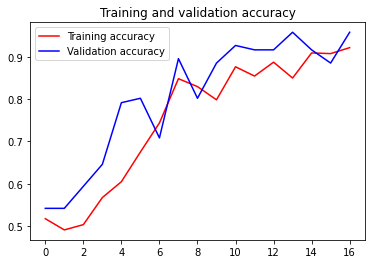

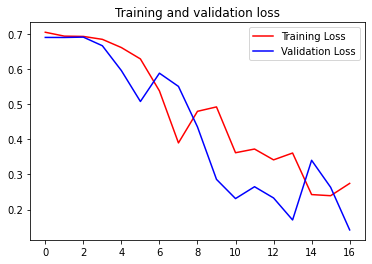

In [36]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

## Model TF-Lite

In [37]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

INFO:tensorflow:Assets written to: /tmp/tmpnjzpen6u/assets


In [38]:
with tf.io.gfile.GFile('model.tflite', 'wb') as f:
    f.write(tflite_model)